<a href="https://colab.research.google.com/github/Yohoh/one-pixel-attack-keras/blob/master/one_pixel_attack_uebung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung
# One Pixel Attack
## auf Basis des Cifar10 Datasets

### Yannis Heim

# Teil 1

In diesem Colab Script soll verdeutlicht werden, wie ein Angriff gegen ein Image Classifier Netzwerk durchgeführt werden kann.
Gezeigt wird dies am Beispiel des [One Pixel Attack](https://arxiv.org/abs/1710.08864).

Dabei werden die einzelnen Bestandteile und deren Implementierung genauer erläutert.

![](images/pred2.png "All it takes is one pixel")

## Colab starten

Da in diesem Skript Code ausgeführt wird, welcher leistungsintensiv ist, sollte das Skript mit GPU Hardwarebeschleunigung ausgeführt werden.
Dazu ist der Laufzeittyp zu ändern.

Öffnet dazu das Drop-down Menu bei "Verbinden" und wählt "Ressourcen ansehen".
Wählt dort "Laufzeittyp ändern" aus und stellt die Hardwarebeschleunigung auf GPU und speichert die Einstellung.

## Imports

Zuerst müssen einige Imports installiert werden, die das Skript benötigt.

Führt dazu die Codezelle unter diesem Text aus. 
Dabei wird ein GitHub Repo gecloned, in dem benötigte Methoden und KI-Modelle hinterlegt sind.
Ebenso werden alle anderen wichtigen Imports getätigt.

Der Vorteil von Jupyter Notebooks wie diesem ist es, dass eine Zelle nur einmal ausgeführt werden muss und die Ausführung in der Laufzeit des Notebooks gespeichert wird.

In [14]:
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Yohoh/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

from scipy.optimize import differential_evolution

# Vortrainierte Netzwerke
from networks.lenet import LeNet
from networks.resnet import ResNet

# Hilfsfunktionen
#from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 475 (delta 80), reused 124 (delta 74), pack-reused 340
Receiving objects: 100% (475/475), 45.91 MiB | 27.56 MiB/s, done.
Resolving deltas: 100% (278/278), done.
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
mv: cannot move 'one-pixel-attack-keras/images' to './images': Directory not empty
renamed 'one-pixel-attack-keras/LICENSE' -> './LICENSE'
mv: cannot move 'one-pixel-attack-keras/networks' to './networks': Directory not empty
renamed 'one-pixel-attack-keras/one_pixel_attack_uebung.ipynb' -> './one_pixel_attack_uebung.ipynb'


## Laden des Cifar10 Datasets

Für unseren Angriff wird das [Cifar10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html) verwendet. Dieses Dataset enthält 32x32 Pixel große Bilder, die einer von 10 Kategorien zugeordnet sind.

Der unten gezeigte Code lädt dieses Datenset.

`x` enthält hierbei die einzelnen Bilder als multidimensionale Arrays.

`y` beschreibt die dazugehörigen Labels wie `bird`.

In [16]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Hier werden die 10 Labels der Kategorien des Cifar10 Datensets geladen.

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Mithilfe der `helper` Funktion können wir nun Bilder anzeigen lassen, indem wir mithilfe eines Indizes auf das `x_test` Array zugreifen.

Zulässig sind Indizes von 0 bis 9999.

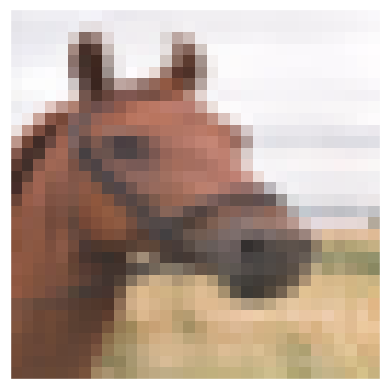

In [18]:
image_id = 99 # Index des Bildes aus Testset das geladen werden soll
helper.plot_image(x_test[image_id])

## Pixelmanipulation

Als allererstes brauchen wir eine Funktion, die in der Lage ist, Pixel in einem Bild zu verändern.

Hierzu wird jedes Pixel als 5-tupel definiert.

$$\textbf{x} = (x, y, r, g, b)$$

Dabei sind $x$ und $y$ die Koordinaten des Pixels im Bild (jeweils von 0 bis 31). $r,g,b$ geben die Farbwerte des Pixels an (jeweils von 0 bis 255).

Mehrere dieser Veränderungen, auch Pertubations genannt, werden wie folgt verkettet:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

Grund dafür ist, dass der Optimierungsalgorithmus, der später vorgestellt wird, ein eindimensionales Array als Eingabe erwartet.

Zumsammengefasst bedeutet das, dass die Funktion ein Bild sowie den Pertubationvektor $X$ als Eingabe erhält und als Ausgabe ein Bild produziert, welches die veränderten Pixel enthält.

Da es später notwendig ist, dass aus einem Bild viele Versionen mit unterschiedlichen Pixelmanipulationen erzeugt werden, fasst man mehrere Pertubations zu $X_S$ zusammen.


In [19]:
def perturb_image(xs, img):
    # wenn nur ein Vektor gegeben wird,
    # wird dieser trotzdem in ein Array der Länge 1 gepackt,
    # damit die Berechnung gleich bleibt
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # das Bild wird nun so oft kopiert wie es Veränderungen gibt (n==len(xs))
    # um die selbe Anzahl an veränderten Bildern zu erhalten (n veränderte Bilder)
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Sichert zu, dass Inhalt von xs nur aus Integer Werten besteht
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # nun wird der Veränderungsvektor in seine einzelnen 5-tupel Bestandteile zerlegt
        # z.b. [[x,y,r,g,b],[x2,y2,r2,g2,b2], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # nun wird dem Pixel sein neuer RGB Wert zugewiesen
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Jetzt sind wir in der Lage, jedes Pixel eines Bildes zu verändern.

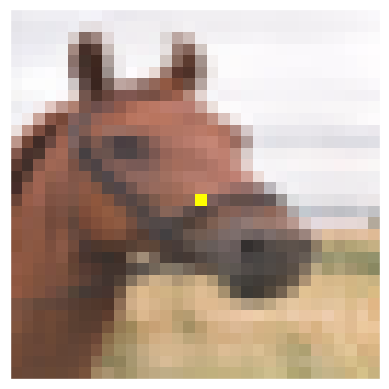

In [20]:
image_id = 99
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

## Laden von vortrainierten KI-Modellen

Um überhaupt einen Angriff auszuführen, brauchen wir erst ein KI-Netzwerk.
Hier sind 2 Netzwerke enthalten, LeNet und ResNet.
Diese sind bereits auf das Cifar10 Datenset trainiert.


In [21]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]

Successfully loaded lenet
Successfully loaded resnet


## Vorhersage Funktion

Da wir in der Lage sein wollen, die selbe Methode auf unterschiedliche Image Classfier anzuwenden, sind für uns nur die Inputs und Outputs der Netzwerke von Bedeutung. Das heißt, wir behandeln die KI als "Black-Box" Algorithmus.

Bei den Outputs ist vorallem die Confidence von Bedeutung. Diese gibt an, wie sicher sich ein Netzwerk mit seiner Zuordnung eines Bildes zu einer bestimmten Klasse ist.

Diese Methode verwendet nun die `predict` Funktion eines Keras KI-Modells.

Ziel wird es später, die Confidence der tatsächlich korrekten Klasse zu senken oder, je nach Art des Angriffs, die Confidence einer bestimmten anderen Zielklasse zu steigern.

Da wir den selben Optimierungsalgorithmus für beide Fälle verwenden, wird hier eine Unterscheidung durchgeführt. Der Optimierungsalgorithmus, der die optimale Position und Farbe eines Pixels ermittelt, ist nur in der Lage, ein Minimum zu finden. Dadurch wird im zweiten Fall `1-predictions` zurückgegeben.

In [22]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Verändern des Bildes mithilfe des Pertubationvektors xs
    imgs_perturbed = perturb_image(xs, img)
    # Confidence des Netzwerkes wird ermittelt, mit welcher das veränderte Bild Teil der Zielklasse ist
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # Diese Funktion wird immer minimiert, deshalb wird hier zwischen zwei Fällen unterschieden
    return predictions if minimize else 1 - predictions

Unten wird dieses Verhalten exemplarisch demonstriert.

In diesem Beispiel, wurden sowohl die Position als auch die Farbe des Pixels bereits optimiert.

1/1 [==============================] - 0s 57ms/step
Confidence in true class  bird is 0.00018887446 %
Prior Confidence was  0.70661753 %


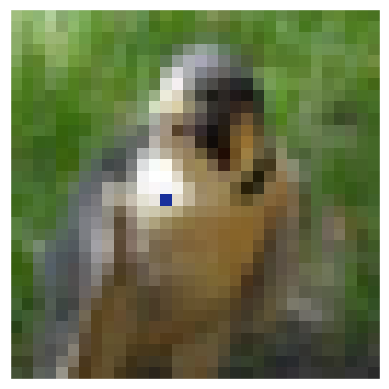

In [23]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class ', class_names[true_class], 'is', confidence,'%')
print('Prior Confidence was ', prior_confidence, '%')
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

# Teil 2

## Der Angriff
Nun können wir den eigentlichen Angriff aufbauen.

### Erfolgskriterium

Nun muss eine Funktion definiert werden, welche angibt, ob ein Angriff erfolgreich war.

Da dies abhängig von der Art des Angriffs ist, wird ein ``targeted_attack`` Flag verwendet, um die zwei Angriffstypen zu unterscheiden.

In [24]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Verändern des Bildes durch Manipulation von Pixeln
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # gibt nur an, wie die Ausgabe erfolgen soll
    if verbose:
        print('Confidence:', confidence[target_class])
    # Wenn der Angriff erfolgreich war, wird True zurückgegeben
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # ist der Angriff kein Erfolg, wird None zurückgegeben, dies wird für die Optimierung wichtig (Eigenheit von SciPy)

Unten wird die Funktionsweise demonstriert.

1/1 [==============================] - 0s 36ms/step
Confidence: 0.07460071
Prior Confidence was 0.50054216 %
Attack success: True


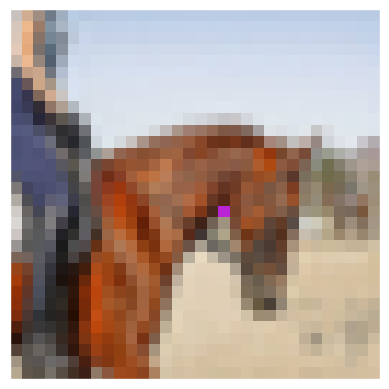

In [25]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior Confidence was', prior_confidence,'%')
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

### Angriffsfunktion

Nun fehlt nur noch die eigentliche Angriffsfunktion, welche die oben entwickelten Methoden mit dem Differential Evolution Optimierungsalgorithmus zusammenfügt.

Hier wird eine [leicht angepasste Version](differential_evolution.py) des [SciPy Differential Evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html) Algorithmus verwendet, um die GPU-Beschleunigung durch Parallelisierung besser nutzbar zu machen.

Die zu optimierende Funktion ist hierbei die `predict_classes` Methode, welche minimiert werden soll.




In [30]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Zielklasse muss angepasst werden, je nachdem, ob targeted oder untargeted attack
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # der Algorithmus benötigt die Grenzwerte aller Parameter (x,y,r,g,b)
    # sollen mehrere Pixel verändert werden, wird die bounds liste so oft wiederholt
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # werden mehrere Pixel verändert, wird die Anzahl der Mitglieder der ersten Population entsprechend gesenkt
    popmul = max(1, popsize // len(bounds))
    
    # die zuvor erstellte predict_classes Methode wird als zu optimierende Funktion und attack_succes als Callback umgeschrieben
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Aufruf des Differential Evolution Algorithmus
    #attack_result = differential_evolution(
    #    predict_fn, bounds, maxiter=maxiter, popsize=popmul,
    #    recombination=1, atol=-1, callback=callback_fn, polish=False)
    attack_result=differential_evolution(predict_fn,bounds,maxiter=maxiter,popsize=popmul,recombination=1,atol=-1,callback=callback_fn,polish=False)
    # Nützliche Kennzahlen berechnen
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]

    # Ergebnisbild nach der Suche ausgeben
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

### Untargeted Attack

Nun können wir ein Bild aus dem Cifar10-Datensatz angreifen!
Hier wird ein Bild mit einem untargeted Attack erfolgreich angegriffen.
Man sieht, wie die Confidence langsam sinkt, bis das Bild falsch klassifiziert wird.

Probiert aus, ob ihr andere Bilder erfolgreich manipulieren könnt. Dazu könnt ihr die Parameter des nächsten Codeblocks anpassen. Also die `image_id`, die Anzahl der maximal zu verändernten Pixel und das verwendetete KI-Modell.

1/1 [==============================] - 0s 35ms/step
Confidence: 0.99352187
1/1 [==============================] - 0s 46ms/step
Confidence: 0.9077995
1/1 [==============================] - 0s 46ms/step
Confidence: 0.9077995
1/1 [==============================] - 0s 68ms/step
Confidence: 0.5583206
1/1 [==============================] - 0s 37ms/step
Confidence: 0.51718056
1/1 [==============================] - 0s 40ms/step
Confidence: 0.37750998
1/1 [==============================] - 0s 35ms/step


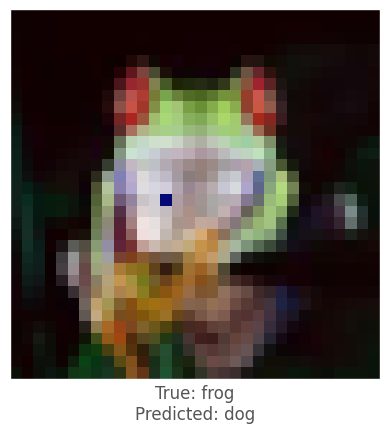

In [31]:
image_id = 102 # gültig zwischen 0 und 9999
pixels = 1
model = resnet # Es stehen resnet und lenet zur Auswahl

_ = attack(image_id, model, pixel_count=pixels, verbose=True)

### Targeted Attack

Unten wird mit dem `LeNet` Modell ein Bild der Klasse `ship` als ein `automobile` erkannt.

Probiert die Parameter zu ändern, um weitere Beispiele zu finden.


In [ ]:
image_id = 108 # gültig zwischen 0 und 9999
# Zielklasse als Integer Index zwischen 0 und 9
# 0 = airplane, 1 = automobile, 2 = bird, 3 = cat, 4 = deer, 5 = dog, 6 = frog, 7 = horse, 8 = ship, 9 = truck
target_class = 1
pixels = 3
model = lenet # Es stehen resnet und lenet zur Auswahl

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)